Steps to Load Model and Run RUDD Dataset

In [ ]:
from fastai.vision import *
from fastai.vision.interpret import *
from fastai.callbacks.hooks import *
from pathlib import Path
from fastai.utils.mem import *
torch.backends.cudnn.benchmark=True

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
path = Path('gdrive/My Drive/Road-surface-detection-and-differentiation-considering-surface-damages-master/RUDD/')
path.ls()

[PosixPath('gdrive/My Drive/Road-surface-detection-and-differentiation-considering-surface-damages-master/RUDD/codes.txt'),
 PosixPath('gdrive/My Drive/Road-surface-detection-and-differentiation-considering-surface-damages-master/RUDD/images'),
 PosixPath('gdrive/My Drive/Road-surface-detection-and-differentiation-considering-surface-damages-master/RUDD/export.pkl'),
 PosixPath('gdrive/My Drive/Road-surface-detection-and-differentiation-considering-surface-damages-master/RUDD/labels'),
 PosixPath('gdrive/My Drive/Road-surface-detection-and-differentiation-considering-surface-damages-master/RUDD/valid.txt')]

In [ ]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['background', 'roadAsphalt', 'roadPaved', 'roadUnpaved', 'roadMarking', 'speedBump', 'catsEye', 'stormDrain',
       'manholeCover', 'patchs', 'waterPuddle', 'pothole', 'craks'], dtype='<U12')

In [ ]:
path_img = path/'images'
path_lbl = path/'labels'

In [ ]:
fnames = get_image_files(path_img)
fnames[:3]
len(fnames)

150

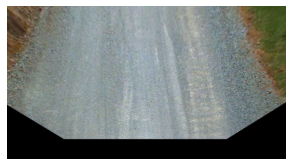

In [ ]:
img_f = fnames[1]
img = open_image(img_f)
img.show(figsize=(5,5))

In [ ]:
src_size = np.array(img.shape[1:])
src_size

array([ 700, 1280])

In [ ]:
def acc_rtk(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [ ]:
get_y_fn = lambda x: path_lbl/f'{x.stem}{x.suffix}'

In [ ]:
learn = load_learner(path)

In [ ]:
prediction = learn.predict(img)

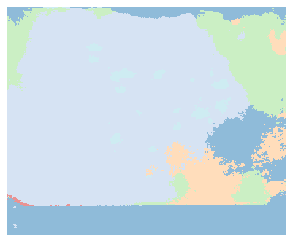

In [ ]:
prediction[0].show(figsize=(5,5))

In [ ]:
# size = src_size

# free = gpu_mem_get_free_no_cache()
# # the max size of bs depends on the available GPU RAM
# if free > 8200: bs=8
# else:           bs=4
# print(f"using bs={bs}, have {free}MB of GPU RAM free")

In [ ]:
# src = (SegmentationItemList.from_folder(path_img)
#        .split_by_fname_file('../valid.txt')
#        .label_from_func(get_y_fn, classes=codes))

In [ ]:
# data = (src.transform(get_transforms(), size=size, tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

In [ ]:
# interp = SegmentationInterpretation.from_learner(learn)

## 6. Saving the Results

---



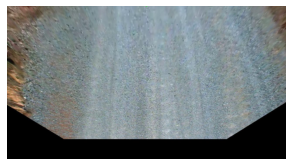

In [ ]:
img_f = fnames[65]
img = open_image(img_f)
img.show(figsize=(5,5))

In [ ]:
prediction = learn.predict(img)

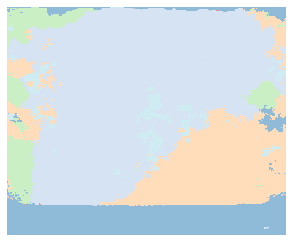

In [ ]:
prediction[0].show(figsize=(5,5))

In [ ]:
results_save = 'results'
path_rst = path/results_save
print(path_rst)

path_rst.mkdir(exist_ok=True)

gdrive/My Drive/Road-surface-detection-and-differentiation-considering-surface-damages-master/RUDD/results


In [ ]:
# fnames

In [ ]:
def save_preds(names):
    i=0
    # names = dl.dataset.items
    
    for b in names:
        img_s = fnames[i]
        # print(img_s)

        img_toSave = open_image(img_s)
        # print(img_toSave)

        img_split = f'{img_s}'
        # print(img_split)

        img_split = img_split[115:]
        # print(img_split)

        predictionSave = learn.predict(img_toSave)
        
        predictionSave[0].save(path_rst/img_split) #Save Image
        print(path_rst/img_split)

        i += 1
        print(i)

In [ ]:
str(fnames[110])[115:]

'row-1-63.jpg'

In [ ]:
save_preds(fnames)

gdrive/My Drive/Road-surface-detection-and-differentiation-considering-surface-damages-master/RUDD/results/row-1-1.jpg
1
gdrive/My Drive/Road-surface-detection-and-differentiation-considering-surface-damages-master/RUDD/results/row-1-10.jpg
2
gdrive/My Drive/Road-surface-detection-and-differentiation-considering-surface-damages-master/RUDD/results/row-1-100.jpg
3
gdrive/My Drive/Road-surface-detection-and-differentiation-considering-surface-damages-master/RUDD/results/row-1-101.jpg
4
gdrive/My Drive/Road-surface-detection-and-differentiation-considering-surface-damages-master/RUDD/results/row-1-102.jpg
5
gdrive/My Drive/Road-surface-detection-and-differentiation-considering-surface-damages-master/RUDD/results/row-1-103.jpg
6
gdrive/My Drive/Road-surface-detection-and-differentiation-considering-surface-damages-master/RUDD/results/row-1-104.jpg
7
gdrive/My Drive/Road-surface-detection-and-differentiation-considering-surface-damages-master/RUDD/results/row-1-105.jpg
8
gdrive/My Drive/Roa

## 7. Coloring the Results

---




In [ ]:
import os
import glob
import base64
import cv2 as cv
cv.__version__

'4.1.2'

In [ ]:
colored_results = 'results_color'
path_crst = path/colored_results
path_crst.mkdir(exist_ok=True)

In [ ]:
%load_ext cython

In [ ]:
%%cython -a
import cython
cimport numpy
import cv2 as cv
import numpy as np

@cython.boundscheck(False)
@cython.wraparound(False)
#def colorfull_fast(numpy.ndarray[numpy.uint8_t, ndim=3, mode="c"] frame):
cpdef numpy.ndarray[numpy.uint8_t, ndim=3, mode="c"] colorfull_fast(numpy.ndarray[numpy.uint8_t, ndim=3, mode="c"] frame):
  # set the variable extension types
  cdef int x, y, width, height, b, g, r

  #frame = cv.imdecode(np.frombuffer(byteframe, np.uint8), -1)

  # grab the image dimensions
  width = 288
  height = 352
  # width = 1280
  # height = 700
    
  # loop over the image, pixel by pixel
  for x in range(width):
    for y in range(height):
      b, g, r = frame[x, y]
      if (b, g, r) == (0,0,0): #background
        frame[x, y] = (0,0,0)
      elif (b, g, r) == (1,1,1): #roadAsphalt
        frame[x, y] = (85,85,255)
      elif (b, g, r) == (2,2,2): #roadPaved
        frame[x, y] = (85,170,127)
      elif (b, g, r) == (3,3,3): #roadUnpaved
        frame[x, y] = (255,170,127) 
      elif (b, g, r) == (4,4,4): #roadMarking
        frame[x, y] = (255,255,255) 
      elif (b, g, r) == (5,5,5): #speedBump
        frame[x, y] = (255,85,255)
      elif (b, g, r) == (6,6,6): #catsEye
        frame[x, y] = (255,255,127)          
      elif (b, g, r) == (7,7,7): #stormDrain
        frame[x, y] = (170,0,127) 
      elif (b, g, r) == (8,8,8): #manholeCover
        frame[x, y] = (0,255,255) 
      elif (b, g, r) == (9,9,9): #patchs
        frame[x, y] = (0,0,127) 
      elif (b, g, r) == (10,10,10): #waterPuddle
        frame[x, y] = (170,0,0)
      elif (b, g, r) == (11,11,11): #pothole
        frame[x, y] = (255,0,0)
      elif (b, g, r) == (12,12,12): #cracks
        frame[x, y] = (255,85,0)
 
  frame = cv.cvtColor(frame,cv.COLOR_BGR2RGB)
  
  # return the colored image
  return frame

In [ ]:
import timeit
# Count variables
fqtd = 0

filenames = [img for img in glob.glob(str(path_rst/"*.jpg"))]

filenames.sort() # ADD THIS LINE

# print(filenames[0:5])

for img in filenames:
  frame = cv.imread(img)

  #%timeit colorfull_fast(frame)
  
  frame = colorfull_fast(frame)
  # name = "%09d.png"%fqtd
  name = img[107:]
  # print(name)

  cv.imwrite(os.path.join(path_crst, name), frame)

  fqtd += 1
  print(fqtd)

print("Done!")

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
Done!
